In [1]:
import pandas as pd
df = pd.read_csv("WindSpeed.csv")
df.head()

,AirportID,Month,Day,Time,TimeZone,SkyCondition,DryBulbFarenheit,WetBulbFarenheit,DewPointFarenheit,RelativeHumidity,...,Day_cos,SkyCondition_Encoded,AirportID_Encoded,Month_sin,Month_cos,UTC_Offset,TimeZone_Region,Is_Western,Is_Eastern,Scored Labels
0,12892,6,14,1253,-8,FEW025,0.575758,0.704225,0.718750,0.581633,...,-0.874347,90,26,1.224647e-16,-1.000000e+00,-8,Far_West,1,0,11.406293
1,13830,9,2,1154,-10,FEW030,0.737374,0.873239,0.833333,0.510204,...,0.979530,-72,37,-1.000000e+00,-1.836970e-16,-10,Far_West,1,0,18.680496
2,12339,9,15,2354,-5,OVC050,0.484848,0.647887,0.708333,0.775510,...,-0.954139,-2,22,-1.000000e+00,-1.836970e-16,-5,Central,0,1,6.978602
3,15016,7,4,2251,-6,FEW250,0.575758,0.746479,0.770833,0.704082,...,0.820763,-69,62,-5.000000e-01,-8.660254e-01,-6,West,0,0,6.667828
4,14492,10,1,351,-5,FEW055,0.373737,0.535211,0.656250,0.959184,...,1.000000,-35,48,-8.660254e-01,5.000000e-01,-5,Central,0,1,0.470526


In [2]:
df = df.dropna(subset=['WindSpeed', 'Scored Labels'])

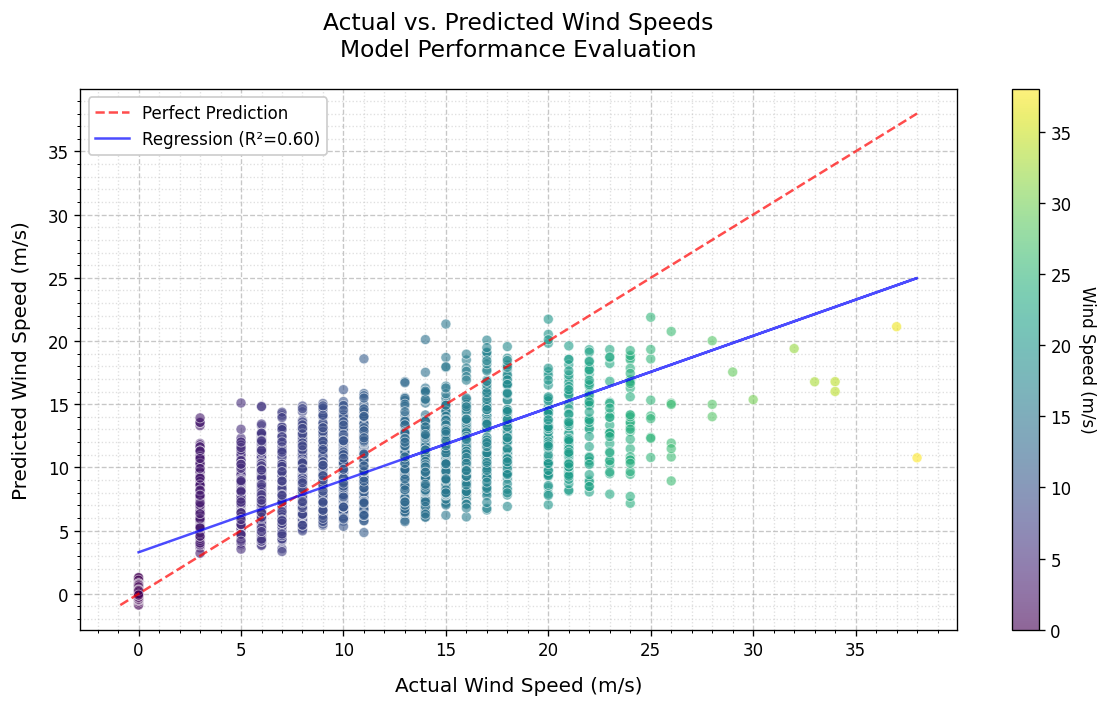

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import AutoMinorLocator

def create_high_quality_windspeed_plot(df, figsize=(10, 6), dpi=120, regression_line=True):
    """
    Creates a publication-quality scatter plot comparing actual vs predicted wind speeds.
    
    Parameters:
        df (pd.DataFrame): DataFrame containing 'WindSpeed' and 'Scored Labels' columns
        figsize (tuple): Figure dimensions (width, height) in inches
        dpi (int): Resolution in dots per inch
        regression_line (bool): Whether to add a linear regression line
    """
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Create scatter plot with semi-transparent points
    scatter = plt.scatter(
        df['WindSpeed'], 
        df['Scored Labels'],
        alpha=0.6,
        edgecolors='w',
        linewidths=0.5,
        c=df['WindSpeed'],  # Color points by wind speed
        cmap='viridis'
    )
    
    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Wind Speed (m/s)', rotation=270, labelpad=15)
    
    # Add perfect prediction line (y=x)
    min_val = min(df['WindSpeed'].min(), df['Scored Labels'].min())
    max_val = max(df['WindSpeed'].max(), df['Scored Labels'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 
             'r--', lw=1.5, alpha=0.7, label='Perfect Prediction')
    
    # Add regression line if requested
    if regression_line:
        from scipy.stats import linregress
        slope, intercept, r_value, _, _ = linregress(df['WindSpeed'], df['Scored Labels'])
        plt.plot(df['WindSpeed'], slope*df['WindSpeed'] + intercept, 
                 'b-', lw=1.5, alpha=0.7, 
                 label=f'Regression (R²={r_value**2:.2f})')
    
    # Formatting
    plt.xlabel('Actual Wind Speed (m/s)', fontsize=12, labelpad=10)
    plt.ylabel('Predicted Wind Speed (m/s)', fontsize=12, labelpad=10)
    plt.title('Actual vs. Predicted Wind Speeds\nModel Performance Evaluation', 
              fontsize=14, pad=20)
    
    # Grid and ticks
    plt.gca().set_axisbelow(True)
    plt.grid(True, which='major', linestyle='--', alpha=0.7)
    plt.grid(True, which='minor', linestyle=':', alpha=0.4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    
    # Legend and layout
    plt.legend(fontsize=10, framealpha=1)
    plt.tight_layout()
    
    return plt

# Usage example:
plot = create_high_quality_windspeed_plot(df)
plot.show()

=== Residual Statistics ===
Mean: -0.00 m/s (Bias)
Std Dev: 3.22 m/s
Skewness: 0.98
Kurtosis: 2.87


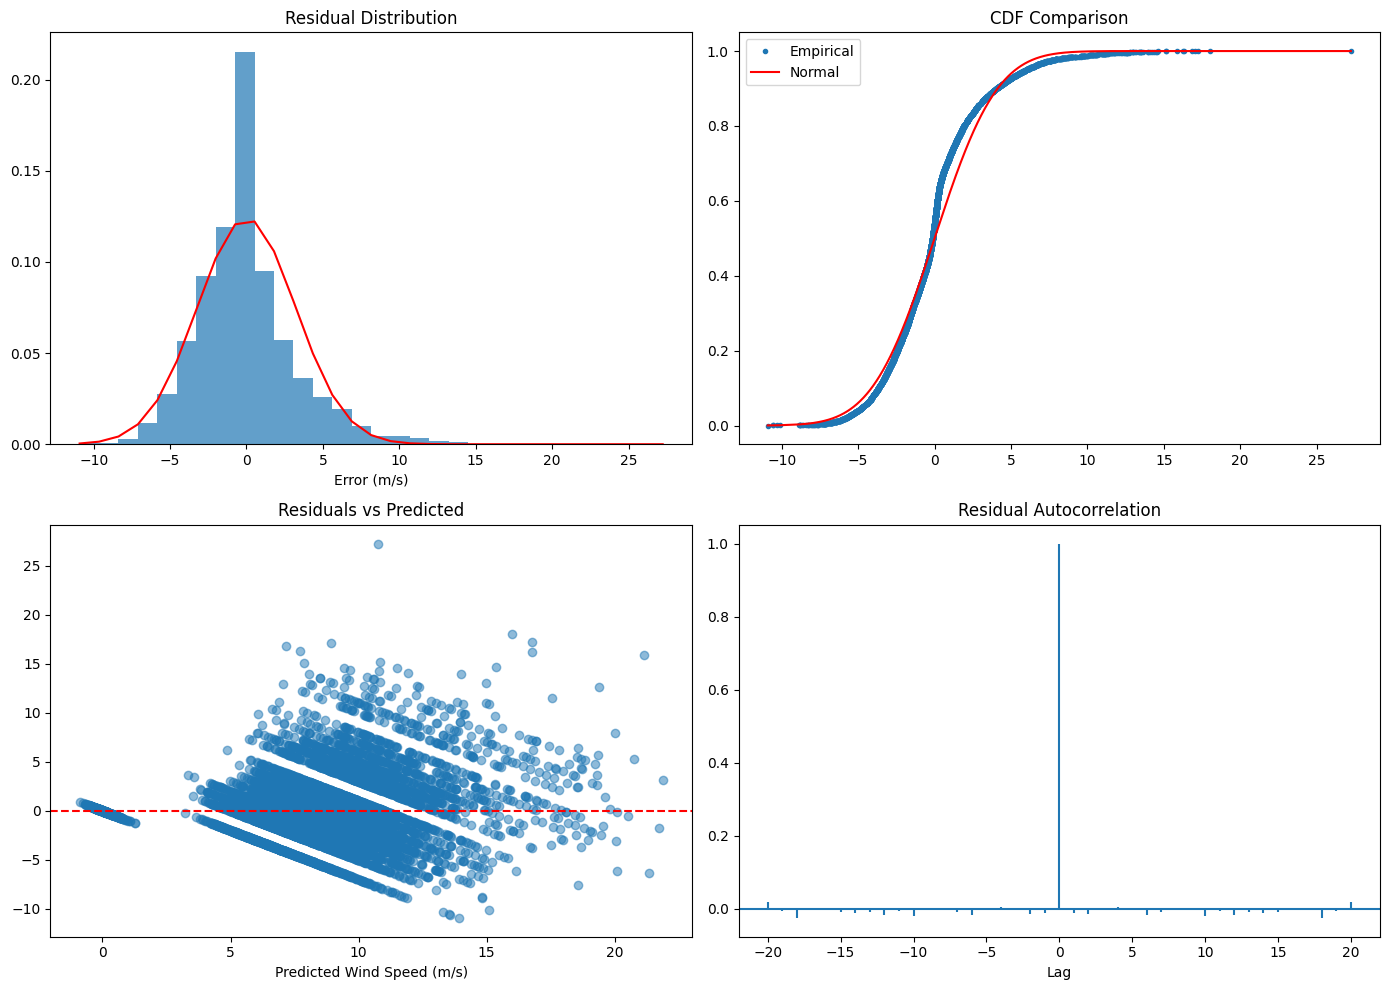

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def residual_analysis(df, actual_col='WindSpeed', pred_col='Scored Labels'):
    residuals = df[actual_col] - df[pred_col]
    
    # 1. Basic Statistics
    print("=== Residual Statistics ===")
    print(f"Mean: {np.mean(residuals):.2f} m/s (Bias)")
    print(f"Std Dev: {np.std(residuals, ddof=1):.2f} m/s")
    print(f"Skewness: {stats.skew(residuals):.2f}")
    print(f"Kurtosis: {stats.kurtosis(residuals):.2f}")
    
    # 2. Create figure
    plt.figure(figsize=(14, 10))
    
    # Panel 1: Histogram with normal curve
    plt.subplot(2, 2, 1)
    n, bins, _ = plt.hist(residuals, bins=30, density=True, alpha=0.7)
    mu, sigma = np.mean(residuals), np.std(residuals)
    plt.plot(bins, stats.norm.pdf(bins, mu, sigma), 'r-')
    plt.title('Residual Distribution')
    plt.xlabel('Error (m/s)')
    
    # Panel 2: Empirical CDF vs Normal CDF (alternative to Q-Q)
    plt.subplot(2, 2, 2)
    x = np.sort(residuals)
    y = np.arange(1, len(x)+1)/len(x)
    plt.plot(x, y, marker='.', linestyle='none', label='Empirical')
    plt.plot(x, stats.norm.cdf(x, mu, sigma), 'r-', label='Normal')
    plt.title('CDF Comparison')
    plt.legend()
    
    # Panel 3: Residuals vs Predicted
    plt.subplot(2, 2, 3)
    plt.scatter(df[pred_col], residuals, alpha=0.5)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Residuals vs Predicted')
    plt.xlabel('Predicted Wind Speed (m/s)')
    
    # Panel 4: Residual Autocorrelation
    plt.subplot(2, 2, 4)
    plt.acorr(residuals - np.mean(residuals), maxlags=20)
    plt.title('Residual Autocorrelation')
    plt.xlabel('Lag')
    
    plt.tight_layout()
    plt.show()

# Run analysis
residual_analysis(df)